In [1]:
import numpy as np
import pandas as pd

import os

import torch
from torch import nn
from torchvision.io import read_image
from torchvision.transforms import v2

from matplotlib import pyplot as plt

"\n\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n    \n"

In [2]:
class Photos(torch.utils.data.Dataset):
    def __init__(self, dir_name):
        self.dir_name = dir_name
        self.data = pd.read_csv(os.path.join(dir_name, 'cat_dog.csv'))
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        image_name = self.data.iloc[index, 0]
        image_label = self.data.iloc[index, 1]
        image = read_image(os.path.join(self.dir_name, 'cat_dog', image_name)) / 255.0
        resize = v2.Resize(size=(100, 100))
        image = resize(image)
        return image, image_label

In [4]:
data = torch.utils.data.DataLoader(Photos('/kaggle/input/cat-dog-images-for-classification'), batch_size=25, shuffle=True)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


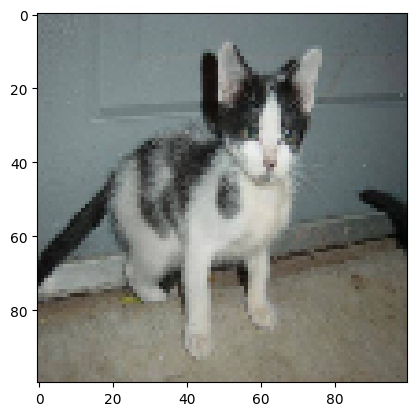

In [178]:
image, _ = next(iter(data))
plt.imshow(image[0].permute(1, 2, 0))
plt.show()

In [9]:
class VAE(nn.Module):
    def __init__(self, dimension):
        super().__init__()
        self.dimension = dimension
        self.flatten = nn.Flatten()
        self.e = nn.Sequential(
            nn.Linear(3*100*100 + 2, 5000), nn.ReLU(), 
            nn.Linear(5000, 128), nn.ReLU()
        )
        self.e_mu = nn.Sequential(
            nn.Linear(128, self.dimension), nn.ReLU()
        )
        self.e_logvar = nn.Sequential(
            nn.Linear(128, self.dimension), nn.ReLU()
        )
        self.d = nn.Sequential(
            nn.Linear(self.dimension + 2, 128), nn.ReLU(),
            nn.Linear(128, 5000), nn.ReLU(),
            nn.Linear(5000, 100*100*3), nn.ReLU(), 
            nn.Unflatten(-1, (3, 100, 100))
        )
    def concatenate(self, a, b):
        return torch.cat((a, b), dim=1)
    def sample(self, mu, std):
        return torch.normal(torch.zeros(mu.shape), torch.ones(mu.shape)) * std + mu
    def encode(self, image, label):
        image = self.flatten(image)
        x = self.concatenate(label, image)
        x = self.e(x)
        mu = self.e_mu(x)
        logvar = self.e_logvar(x)
        std = torch.exp(logvar * 0.5)
        return mu, std
    def decode(self, mu, label):
        x = self.concatenate(label, mu)
        return self.d(x)
    def forward(self, image, label):
        mu, std = self.encode(image, label)
        h = self.sample(mu, std)
        image_out = self.decode(h, label)
        return mu, std, image_out

In [6]:
def vae_loss(image_out, mu, std, image, batch_size):
    mse = nn.functional.mse_loss(image_out, image, reduction='sum')
    dkl = 0.5 * torch.sum(std + torch.pow(mu, 2) - 1 - torch.log(std))
    return (mse + dkl) / batch_size

In [10]:
vae = VAE(2)

In [ ]:
epochs = 1
optimizer = torch.optim.Adam(vae.parameters(), lr=0.0003, betas=[0.9, 0.99])
size = len(data.dataset)
for e in range(1, epochs + 1):
    for i, (image, label) in enumerate(data):
        label = nn.functional.one_hot(torch.tensor(label), 2)
        label = label.to(torch.float32)
        mu, std, image_out = vae(image, label)
        loss = vae_loss(image_out, mu, std, image, data.batch_size)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if i % 10 == 0:
            print(f'Epoch: {e}, image: {(i + 1) * data.batch_size}/{size}, loss = {loss.item()}')

/tmp/ipykernel_33/481086284.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = nn.functional.one_hot(torch.tensor(label), 2)


Epoch: 1, image: 25/25000, loss = 6896.09228515625


In [217]:
torch.save(vae.state_dict(), 'vae4')

tensor([[0., 1.]])


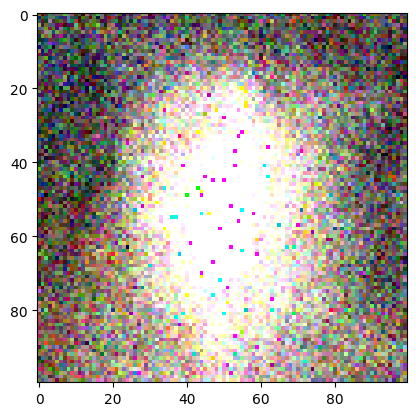

In [232]:
label = nn.functional.one_hot(torch.tensor(1), 2)
label = label.to(torch.float32)
print(torch.unsqueeze(label, 0))
image_new = vae.decode(torch.tensor([[5, -1, -10, 2, -15]], dtype=torch.float32), torch.unsqueeze(label, 0))[0].permute(1, 2, 0).detach().numpy()
plt.imshow(image_new)
plt.show()